# Ejercicio 5

In [ ]:
%%capture
# Instalar la biblioteca pytube
!pip install pytube
!apt update && apt install -y handbrake

In [ ]:
!pip install -q mediapy

In [ ]:
import mediapy as media
url = 'videoplayback.mp4'
video = media.read_video(url)
media.show_video(video)

In [ ]:
import mediapy as media  # Importar la biblioteca mediapy para manejo de medios
import cv2  # Importar OpenCV para el procesamiento de imágenes y videos
import numpy as np


# Función para oscurecer una imagen:
def process_image(new_image, prev_image, **kwargs):
    # Convertir la imagen a float32
    new_image_float = new_image.astype(np.float32)

    # Reducir el brillo de la imagen a la mitad
    new_image_float *= 0.5

    # Convertir la imagen de vuelta a uint8
    new_image_uint8 = np.clip(new_image_float, 0, 255).astype(np.uint8)

    return new_image_uint8

def draw_contours(frame, contours, color=(0, 255, 0), thickness=2):
    # Comprobar si la imagen es en escala de grises (1 canal)
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        # Convertir la imagen de escala de grises a color (3 canales)
        result_image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        # Si ya es una imagen de color, simplemente hacer una copia
        result_image = frame.copy()

    # Dibujar cada contorno en la imagen
    for contour in contours:
        # Obtener el rectángulo delimitador para cada contorno
        x, y, w, h = cv2.boundingRect(contour)
        # Dibujar el rectángulo
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, thickness)

    return result_image

# Función para procesar un video:
def video_processor(filename_in, filename_out, process_func, max_time=10, **kwargs):
    # Abrir el video de entrada para lectura
    with media.VideoReader(filename_in) as r:
        # Crear un archivo de video de salida
        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:
            count = 0  # Inicializar contador de fotogramas
            prev_image = None  # Inicializar la imagen previa

            # Iterar sobre cada imagen (fotograma) del video
            for image in r:
                new_image = media.to_uint8(image)  # Convertir la imagen a formato flotante

                # Comprobar si es la primera imagen
                if prev_image is None:
                    prev_image = new_image.copy()

                # Procesar la imagen utilizando la función dada
                processed_image = process_func(new_image, prev_image, **kwargs)

                # Añadir la imagen procesada al video de salida
                w.add_image(processed_image)

                # Actualizar la imagen previa
                prev_image = new_image.copy()

                # Incrementar el contador de fotogramas
                count += 1

                # Detener el proceso si se alcanza el tiempo máximo
                if count >= max_time * r.fps:
                    break

# Nombres de los archivos de video de entrada y salida
filename_in = 'videoplayback.mp4'
filename_out = 'videoplayback_dark.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_image, 10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

In [ ]:
# Función actualizada para realizar diferencia de fotogramas con normalización:
def process_frame_difference(new_image, prev_image, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv2.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv2.threshold(norm_diff, 60, 255, cv2.THRESH_BINARY)

    # Convertir la imagen umbralizada a color para mantener la consistencia con el video original
    thresh_color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    return thresh_color

# Nombres de los archivos de video de entrada y salida
filename_in = 'videoplayback.mp4_dark.mp4'
filename_out = 'videoplayback.mp4_dark_difference.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_frame_difference, 20)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

In [ ]:
import numpy as np

# Función actualizada para detectar movimientos y dibujar cuadros delimitadores:
def process_frame_difference_full(new_image, prev_image, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv2.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv2.threshold(norm_diff, 60, 255, cv2.THRESH_BINARY)

    # Dilatar la imagen umbralizada para mejorar la detección de contornos
    kernel = np.ones((10,10),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    # Convertir la imagen dilatada a formato adecuado para findContours
    dilated = dilated.astype(np.uint8)

    # Encontrar contornos en la imagen dilatada
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar cuadros delimitadores alrededor de los contornos
    if kwargs.get('draw_mode', 0) == 0:
      result_image = draw_contours(new_image, contours)
    elif kwargs.get('draw_mode', 0) == 1:
      result_image = draw_contours(thresh, contours)

    return result_image


# Nombres de los archivos de video de entrada y salida
filename_in = 'videoplayback.mp4_dark.mp4'
filename_out = 'videoplayback.mp4_dark.mp4_difference_full.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_frame_difference_full,
                max_time=20, draw_mode=1)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

# Llamar a la función para procesar el video
filename_out = 'videoplayback.mp4_dark.mp4_full_2.mp4'
video_processor(filename_in, filename_out, process_frame_difference_full,
                max_time=20, draw_mode=0)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

In [ ]:
import mediapy

def process_sparse_optical_flow(new_image, prev_image):
    # Preparamos las imagenes de trabajo
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    prev_gray_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)

    # Verificar si ya se han detectado las características de Shi-Tomasi
    if not hasattr(process_sparse_optical_flow, "shi_tomasi_done"):
        # Definir parámetros para la detección de esquinas de Shi-Tomasi
        feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
        # Detectar puntos característicos en la imagen
        process_sparse_optical_flow.prev_points = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
        # Crear una máscara para dibujar el flujo óptico
        process_sparse_optical_flow.mask = np.zeros_like(new_image)
        # Marcar que se ha completado la detección de Shi-Tomasi
        process_sparse_optical_flow.shi_tomasi_done = True

    # Continuar si se ha completado la detección de Shi-Tomasi
    if process_sparse_optical_flow.shi_tomasi_done:
        prev_points = process_sparse_optical_flow.prev_points
        mask = process_sparse_optical_flow.mask

    # Parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Calcular el flujo óptico de Lucas-Kanade
    new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # Filtrar puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # Color para el dibujo
    # Dibujar el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        new_image = cv2.circle(new_image, (a, b), 3, color, -1)

    # Combinar la imagen actual con las líneas de flujo óptico dibujadas
    output = cv2.add(new_image, mask)
    # Actualizar puntos para el siguiente cuadro
    process_sparse_optical_flow.prev_points = good_new.reshape(-1, 1, 2)
    return output

# Nombres de los archivos de video de entrada y salida
filename_in = 'videoplayback_dark.mp4'
filename_out = 'videoplayback_process_sparse_optical.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_sparse_optical_flow,
                max_time=10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

In [ ]:
# Función para procesar el flujo óptico denso
def process_dense_optical_flow(new_image, prev_image):
    # Convierte la nueva imagen a escala de grises
    gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    if not hasattr(process_dense_optical_flow, "init_done"):
        process_dense_optical_flow.prev_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        process_dense_optical_flow.mask = np.zeros_like(new_image)
        process_dense_optical_flow.mask[..., 1] = 255
        process_dense_optical_flow.init_done = True

    if process_dense_optical_flow.init_done:
        prev_gray = process_dense_optical_flow.prev_gray
        mask = process_dense_optical_flow.mask

    # Calcula el flujo óptico
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computa magnitud y ángulo de los vectores 2D
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Establece el tono de la imagen según la dirección del flujo óptico
    mask[..., 0] = angle * 180 / np.pi / 2
    # Establece el valor de la imagen según la magnitud del flujo óptico
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convierte de HSV a RGB
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    # Actualiza la imagen previa a gris
    process_dense_optical_flow.prev_grayprev_gray = gray.copy()
    return rgb

# Nombres de los archivos de video de entrada y salida
filename_in = 'videoplayback_dark.mp4'
filename_out = 'videoplayback_dark.mp4_process_dense_optical.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_dense_optical_flow,
                max_time=20)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

# Reflexión

El video tiene demasiadas cosas que el código toma como si tuvieran movimiento, esto hace que se dificulte localizar a las personas. Probé modificar algunos parámetros para limpiar el ruido que generan, pero no logré que queden solamente las personas. Los algoritmos de flujo denso y disperso directamente no funcionan con tanto ruido, se podría intentar en todos los casos con un umbral de área para dejar las componentes conectadas grandes, que serían las personas.



# Ejercicio 6

## <u>Localización de Objetos</u>

La localización de objetos es la tarea de identificar la ubicación precisa de uno o varios objetos dentro de una imagen y delimitarlos con un bounding box. El objetivo es detectar y ubicar objetos específicos en una imagen.

## <u>Clasificación de Imágenes</u>

El objetivo es identificar y clasificar objetos o características dentro de imágenes digitales, asignándole una etiqueta o categoría.

## <u>Ejemplo:</u>
Una imagen que contiene una persona, un perro y un auto.

 - El objetivo de la clasificación de imágenes sería determinar una etiqueta general para la imagen, como "persona", "perro", "coche" o "exterior".
 - En el caso de la localización de objetos sería identificar y delimitar cada uno de estos objetos con un bounding box.

#Clasificación de Imágenes

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

# Cargar el modelo preentrenado EfficientNetB0
model = EfficientNetB0(weights='imagenet')

def classify_image(img_path):
    # Cargar y preparar la imagen
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Tamaño de entrada para EfficientNetB0

    # Convertir la imagen a un array y procesarla
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Realizar la predicción con el modelo
    predictions = model.predict(img_array)

    # Decodificar y retornar las predicciones
    return decode_predictions(predictions, top=3)[0]

21834768/21834768 [==============================] - 2s 0us/step


In [2]:
# Prueba con una imagen local
img_path = 'IMG-20201230-WA0005.jpg'  # Reemplaza con la ruta de tu imagen
predictions = classify_image(img_path)

print('\n')

# Mostrar las predicciones
for i, (imagenet_id, label, score) in enumerate(predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

35363/35363 [==============================] - 0s 1us/step


1: Brittany_spaniel (0.49)
2: Welsh_springer_spaniel (0.13)
3: golden_retriever (0.05)


#Localización de objetos y clasificación de imágenes

In [3]:
%%capture
!pip install pixellib torchvision
# Instance segmentation model
!wget "https://github.com/ayoolaolafenwa/PixelLib/releases/download/0.2.0/pointrend_resnet50.pkl" -O pointrend_resnet50.pkl

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


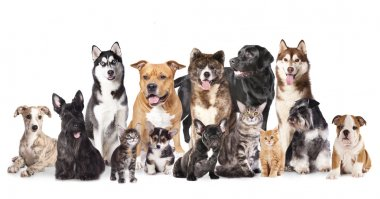

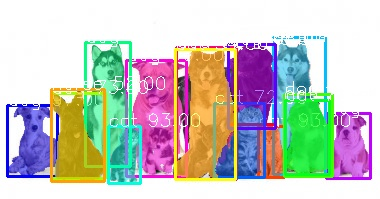

In [4]:
# Instalación de la biblioteca PixelLib
# !pip install pixellib

# Importación de las bibliotecas necesarias
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation
from IPython.display import Image

# Creación de una instancia del modelo de segmentación
ins = instanceSegmentation()

# Carga del modelo preentrenado
ins.load_model("pointrend_resnet50.pkl")

# Segmentación de la imagen y guardado de la imagen segmentada con las cajas delimitadoras
ins.segmentImage("group-of-dogs-and-cats.jpg", show_bboxes=True, output_image_name="group-of-dogs-and-cats_segmented.jpg")

# Muestra la imagen original
display(Image(filename="group-of-dogs-and-cats.jpg"))

# Muestra la imagen segmentada
display(Image(filename="group-of-dogs-and-cats_segmented.jpg"))